# Simplicial Interpolation on Synthetic logistic Data

This notebook evaluates simplicial interpolation methods on synthetic binary classification data generated from logistic regression on Gaussian features. The analysis compares a hybrid simplicial classifier against standard 1-Nearest Neighbor across varying dimensions and noise levels.

## Overview

The notebook implements a **Local Simplicial Classifier** that attempts simplicial interpolation within convex hulls of k-nearest neighbors, falling back to 1-NN when points lie outside any hull. This hybrid approach combines the smoothness of interpolation with the robustness of nearest neighbor methods.

## Goals

- **Hybrid Classification**: Simplicial interpolation with 1-NN fallback
- **Synthetic Data**: Logistic regression on Gaussian features with controllable label noise
- **Comprehensive Evaluation**: Systematic testing across dimensions (3-8) and noise levels (0-30%)
- **Statistical Robustness**: Multiple random seeds for reliable results
- **Performance Comparison**: Error rates and coverage analysis

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import Delaunay
from sklearn.neighbors import KNeighborsClassifier
from scipy.optimize import linprog


class KNNClassifier:
    """Standard 1-NN Classifier"""
    def __init__(self, k=1):
        self.k = k
        self.nn = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        _, idxs = self.nn.kneighbors(X)
        return self.y_train[idxs[:, 0]]

class GlobalSimplicialClassifier:
    """
    Exact Simplicial Interpolation Classifier based on Global Delaunay Triangulation.
    
    Warning: This scales exponentially with dimension 'd'. 
    Recommended only for d <= 6.
    """
    def __init__(self):
        self.tri = None
        self.X_train = None
        self.y_train = None
        self.fallback_nn = KNeighborsClassifier(n_neighbors=1)
        self.coverage_rate_ = 0.0

    def fit(self, X, y):
        """
        Computes the Delaunay Triangulation of the training set.
        """
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        
        self.fallback_nn.fit(self.X_train, self.y_train)
        
        try:
            self.tri = Delaunay(self.X_train)
        except Exception as e:
            print(f"Triangulation failed (likely due to degeneracy or dimensionality): {e}")
            self.tri = None
            
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        y_proba = np.zeros(n_samples)
        
        covered_count = 0
        
        if self.tri is None:
            self.coverage_rate_ = 0.0
            return self.fallback_nn.predict_proba(X)[:, 1]

        simplex_indices = self.tri.find_simplex(X)

        for i in range(n_samples):
            simp_idx = simplex_indices[i]
            
            if simp_idx == -1:
                y_proba[i] = self.fallback_nn.predict_proba(X[i].reshape(1, -1))[0, 1]
                continue
            
            covered_count += 1
            
            vertices_indices = self.tri.simplices[simp_idx]
            T_inv = self.tri.transform[simp_idx, :-1]
            offset = self.tri.transform[simp_idx, -1]
            
            b = T_inv.dot(X[i] - offset)
            b_last = 1.0 - b.sum()
            weights = np.append(b, b_last)
            
            weights = np.clip(weights, 0, 1)
            if weights.sum() > 0:
                weights /= weights.sum()
            else:
                weights = np.ones_like(weights) / len(weights)
            
            local_labels = self.y_train[vertices_indices]
            y_proba[i] = np.dot(weights, local_labels)
            
        self.coverage_rate_ = covered_count / n_samples
        return y_proba

    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas >= 0.5).astype(int)

### For high dimensions:

In case we encounter high dims, the previous method could be computationaly unefficient and even impossible to do. Down bellow, we implemented a local approach to find the closest simplex to a given point.
The coverage with this method will be surely less than the real delaunay triangularization. But, in terms of computation we are extraordinarily faster than the first one

In [3]:
class KNNClassifier:

    """Standard 1-NN Classifier"""

    def __init__(self, k=1):
        self.k = k
        self.nn = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        # Find closest neighbor
        _, idxs = self.nn.kneighbors(X)
        return self.y_train[idxs[:, 0]]

class LocalSimplicialClassifier:

    """
    Hybrid Simplicial Classifier:

    1. Tries to interpolate using Linear Programming (LP).

    2. If point is OUTSIDE hull (LP fails), falls back to 1-NN.

    """

    def __init__(self, k=15):
        self.k = int(k)
        self.nn = None
        self.X_train = None
        self.y_train = None
        self.coverage_rate_ = 0.0

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples, dtype=int)
        success_count = 0
        c = np.zeros(self.k)
        bounds = [(0, None) for _ in range(self.k)]
        dists, idxs = self.nn.kneighbors(X)
        print(f"Solving LP for {n_samples} points...", end="\r")
        for i in range(n_samples):
            local_idx = idxs[i]
            X_loc = self.X_train[local_idx]
            y_loc = self.y_train[local_idx]
            A_eq = np.vstack([X_loc.T, np.ones((1, self.k))])
            b_eq = np.concatenate([X[i], [1.0]])
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                w = res.x
                score = np.dot(w, y_loc)
                y_pred[i] = 1 if score >= 0.5 else 0
                success_count += 1
            else:
                y_pred[i] = y_loc[0]
        self.coverage_rate_ = success_count / n_samples
        return y_pred

    def predict_proba(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        c = np.zeros(self.k)
        bounds = [(0, None) for _ in range(self.k)]
        dists, idxs = self.nn.kneighbors(X)
        d = self.X_train.shape[1]
        for i in range(n_samples):
            local_idx = idxs[i]
            X_loc = self.X_train[local_idx]
            y_loc = self.y_train[local_idx]
            A_eq = np.vstack([X_loc.T, np.ones((1, self.k))])
            b_eq = np.concatenate([X[i], [1.0]])
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                w = res.x
                score = np.dot(w, y_loc)
                y_pred[i] = score
            else:
                y_pred[i] = y_loc[0]
        return y_pred

## Synthetic Data Generation

This cell defines the `make_logistic_gaussian_data` function for generating synthetic binary classification datasets.

### Data Model
- **Features**: X ~ N(0, I_d) - Standard multivariate Gaussian in d dimensions
- **Teacher Vector**: u ~ N(0, I_d), normalized to unit length
- **Clean Labels**: P(y=1|x) = σ(γ * (x·u)) where σ is the sigmoid function
- **Noisy Labels**: Independent flips with probability p_noise

### Key Properties
- **Noise Control**: Allows systematic study of label noise effects
- **Scalability**: Efficient generation for large n and d

In [2]:
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def make_logistic_gaussian_data(n, d, gamma=2.0, p_noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, 1.0, size=(n, d))
    
    # Dense teacher vector
    u = rng.normal(0.0, 1.0, size=d)
    u /= np.linalg.norm(u)
    
    eta = sigmoid(gamma * (X @ u))
    y_clean = (rng.random(n) < eta).astype(int)
    
    # Add noise
    y = y_clean.copy()
    flips = rng.random(n) < p_noise
    y[flips] = 1 - y[flips]
    
    return X, y, y_clean



## Comprehensive Dimension vs Noise Experiment

This cell executes the main experimental evaluation, systematically comparing simplicial interpolation against 1-NN across multiple dimensions and noise levels with statistical averaging.

### Experimental Design
- **Dimensions**: d ∈ {3,4,5,6,7,8}
- **Noise Levels**: p ∈ {0.0, 0.05, 0.1, 0.2, 0.3}
- **Random Seeds**: 5 different seeds for statistical robustness
- **Dataset Size**: 30,000 training samples, 200 test samples per trial
- **k_neighbors**: 3×d (scales with dimensionality)

### Methodology
For each combination of (d, p, seed):
1. **Generate Data**: Create training data with noise p, clean test data (p=0)
2. **Train Models**:
   - 1-NN: Standard nearest neighbor
   - Simplicial: Hybrid interpolation with 1-NN fallback
3. **Evaluate**: Measure error rates and coverage on test set
4. **Aggregate**: Average across 5 seeds for each (d, p) combination

### Metrics Collected
- **1-NN Error**: Classification error of 1-nearest neighbor
- **Simplicial Error**: Error of hybrid simplicial classifier
- **Coverage**: Fraction of test points inside simplicial hulls

### Results Visualization
6-subplot grid (2×3) showing error vs noise curves:
- **Red circles (1-NN)**: 1-Nearest Neighbor error rates
- **Blue squares (Simplicial)**: Hybrid classifier error rates
- **X-axis**: Training label noise (0-30%)
- **Y-axis**: Test error rate (0-1)
- **Titles**: Include average simplicial coverage for each dimension


Running Experiment across dimensions [2, 3, 4, 5]...
Note: Global Delaunay (Simplicial) can be slow for N=15000 in d>=5.

Processing Dimension d=2...
  Noise 0.00 -> 1NN: 0.695, Simp: 0.707 (Cov: 99.80%)
  Noise 0.05 -> 1NN: 0.668, Simp: 0.686 (Cov: 99.80%)
  Noise 0.10 -> 1NN: 0.651, Simp: 0.674 (Cov: 99.80%)
  Noise 0.20 -> 1NN: 0.603, Simp: 0.621 (Cov: 99.80%)
  Noise 0.30 -> 1NN: 0.567, Simp: 0.583 (Cov: 99.80%)

Processing Dimension d=3...
  Noise 0.00 -> 1NN: 0.700, Simp: 0.706 (Cov: 99.80%)
  Noise 0.05 -> 1NN: 0.683, Simp: 0.696 (Cov: 99.80%)
  Noise 0.10 -> 1NN: 0.656, Simp: 0.674 (Cov: 99.80%)
  Noise 0.20 -> 1NN: 0.624, Simp: 0.639 (Cov: 99.80%)
  Noise 0.30 -> 1NN: 0.580, Simp: 0.581 (Cov: 99.80%)

Processing Dimension d=4...
  Noise 0.00 -> 1NN: 0.673, Simp: 0.688 (Cov: 99.50%)
  Noise 0.05 -> 1NN: 0.653, Simp: 0.678 (Cov: 99.50%)
  Noise 0.10 -> 1NN: 0.632, Simp: 0.675 (Cov: 99.50%)
  Noise 0.20 -> 1NN: 0.589, Simp: 0.628 (Cov: 99.50%)
  Noise 0.30 -> 1NN: 0.561, Simp: 0.

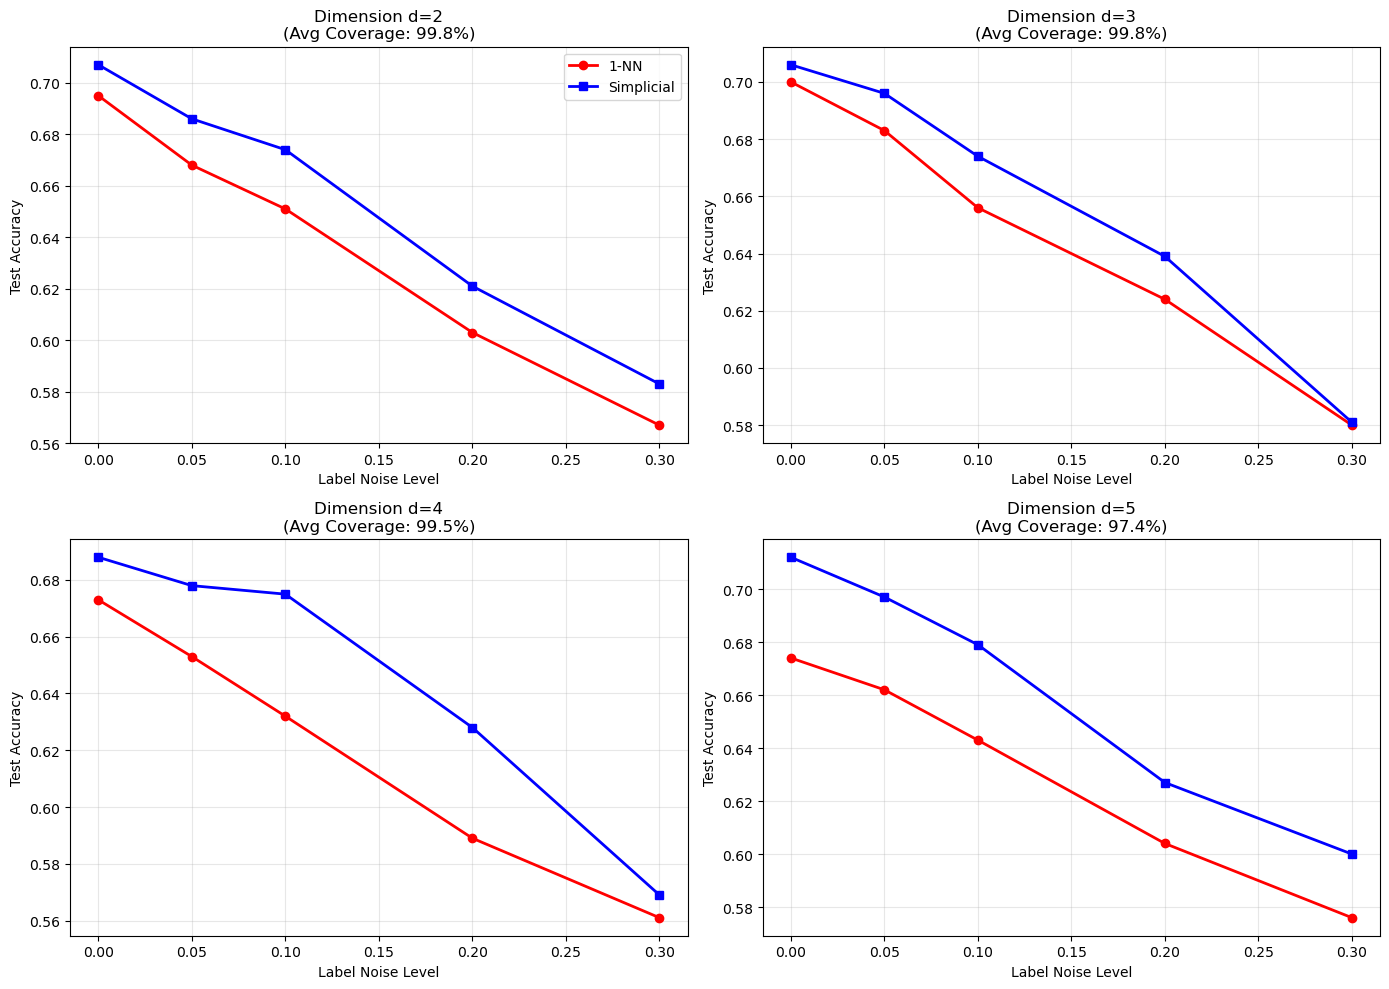

In [11]:
d_values = range(2, 6) 
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)

n_train = 15000 
n_test = 200

results = {}

print(f"Running Experiment across dimensions {list(d_values)}...")
print(f"Note: Global Delaunay (Simplicial) can be slow for N={n_train} in d>=5.")

for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'simp_acc': [], 'cov': []}
    
    print(f"\nProcessing Dimension d={d}...")
    
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            
            ms = GlobalSimplicialClassifier().fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) == yte))
            
            temp_cov.append(ms.coverage_rate_)
            
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['simp_acc'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, "
              f"Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_acc'], 'b-s', label='Simplicial', linewidth=2)
    
    avg_coverage = np.mean(data['cov'])
    
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})", fontsize=12)
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy")
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

Running Experiment across dimensions [6, 8, 10, 12, 14, 16]...

Processing Dimension d=6 (k=18)...
  Noise 0.00 -> 1NN: 0.696, Simp: 0.730 (Cov: 78.30%)
  Noise 0.05 -> 1NN: 0.671, Simp: 0.708 (Cov: 78.30%)
  Noise 0.10 -> 1NN: 0.654, Simp: 0.691 (Cov: 78.30%)
  Noise 0.20 -> 1NN: 0.599, Simp: 0.652 (Cov: 78.30%)
  Noise 0.30 -> 1NN: 0.557, Simp: 0.594 (Cov: 78.30%)

Processing Dimension d=8 (k=24)...
  Noise 0.00 -> 1NN: 0.674, Simp: 0.690 (Cov: 56.50%)
  Noise 0.05 -> 1NN: 0.659, Simp: 0.671 (Cov: 56.50%)
  Noise 0.10 -> 1NN: 0.637, Simp: 0.662 (Cov: 56.50%)
  Noise 0.20 -> 1NN: 0.606, Simp: 0.631 (Cov: 56.50%)
  Noise 0.30 -> 1NN: 0.581, Simp: 0.583 (Cov: 56.50%)

Processing Dimension d=10 (k=30)...
  Noise 0.00 -> 1NN: 0.683, Simp: 0.681 (Cov: 31.30%)
  Noise 0.05 -> 1NN: 0.653, Simp: 0.659 (Cov: 31.30%)
  Noise 0.10 -> 1NN: 0.640, Simp: 0.652 (Cov: 31.30%)
  Noise 0.20 -> 1NN: 0.613, Simp: 0.629 (Cov: 31.30%)
  Noise 0.30 -> 1NN: 0.565, Simp: 0.594 (Cov: 31.30%)

Processing Dimens

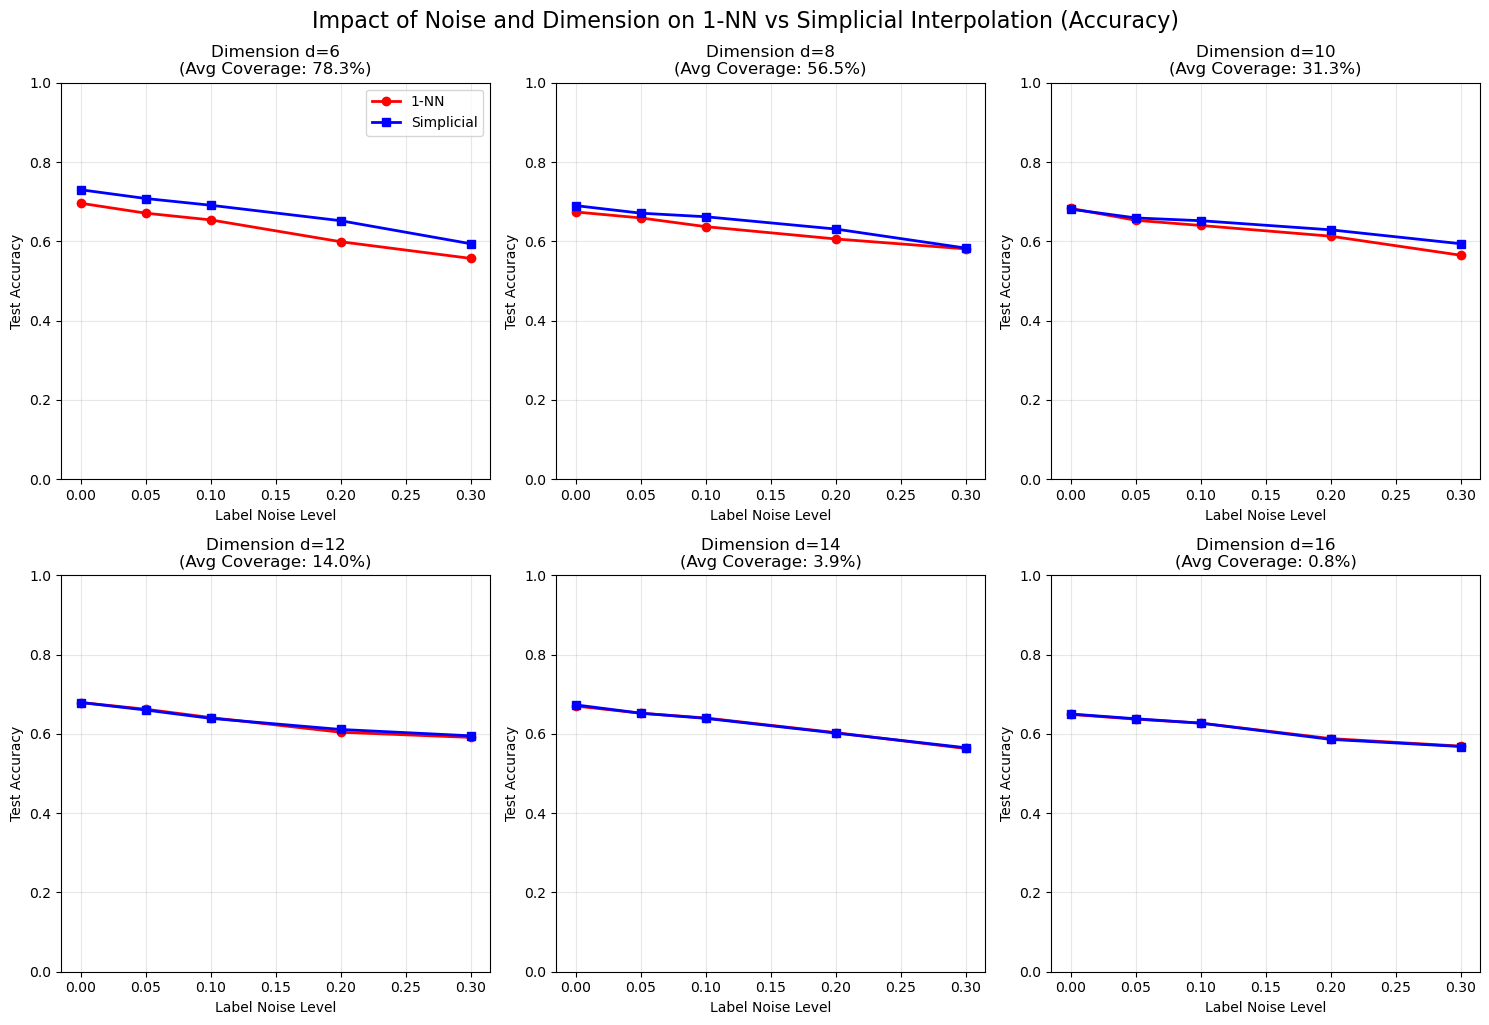

In [6]:
d_values = range(6, 17, 2)
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)
n_train = 3000000
n_test = 200
results = {}
print(f"Running Experiment across dimensions {list(d_values)}...")
for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'simp_acc': [], 'cov': []}
    k_simplicial = d * 3
    print(f"\nProcessing Dimension d={d} (k={k_simplicial})...")
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            ms = LocalSimplicialClassifier(k=k_simplicial).fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) == yte))
            temp_cov.append(ms.coverage_rate_)
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['simp_acc'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_acc'], 'b-s', label='Simplicial', linewidth=2)
    avg_coverage = np.mean(data['cov'])
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})")
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()
plt.tight_layout()
plt.suptitle("Impact of Noise and Dimension on 1-NN vs Simplicial Interpolation (Accuracy)", y=1.02, fontsize=16)
plt.show()

## lower value for N (less coverage):

Running Experiment across dimensions [2, 3, 4, 5]...
Note: Global Delaunay (Simplicial) can be slow for N=1500 in d>=5.

Processing Dimension d=2...
  Noise 0.00 -> 1NN: 0.698, Simp: 0.707 (Cov: 99.40%)
  Noise 0.05 -> 1NN: 0.683, Simp: 0.688 (Cov: 99.40%)
  Noise 0.10 -> 1NN: 0.668, Simp: 0.656 (Cov: 99.40%)
  Noise 0.20 -> 1NN: 0.625, Simp: 0.614 (Cov: 99.40%)
  Noise 0.30 -> 1NN: 0.563, Simp: 0.556 (Cov: 99.40%)

Processing Dimension d=3...
  Noise 0.00 -> 1NN: 0.690, Simp: 0.714 (Cov: 97.00%)
  Noise 0.05 -> 1NN: 0.663, Simp: 0.685 (Cov: 97.00%)
  Noise 0.10 -> 1NN: 0.644, Simp: 0.673 (Cov: 97.00%)
  Noise 0.20 -> 1NN: 0.606, Simp: 0.629 (Cov: 97.00%)
  Noise 0.30 -> 1NN: 0.577, Simp: 0.593 (Cov: 97.00%)

Processing Dimension d=4...
  Noise 0.00 -> 1NN: 0.688, Simp: 0.705 (Cov: 94.30%)
  Noise 0.05 -> 1NN: 0.673, Simp: 0.696 (Cov: 94.30%)
  Noise 0.10 -> 1NN: 0.657, Simp: 0.686 (Cov: 94.30%)
  Noise 0.20 -> 1NN: 0.619, Simp: 0.659 (Cov: 94.30%)
  Noise 0.30 -> 1NN: 0.587, Simp: 0.6

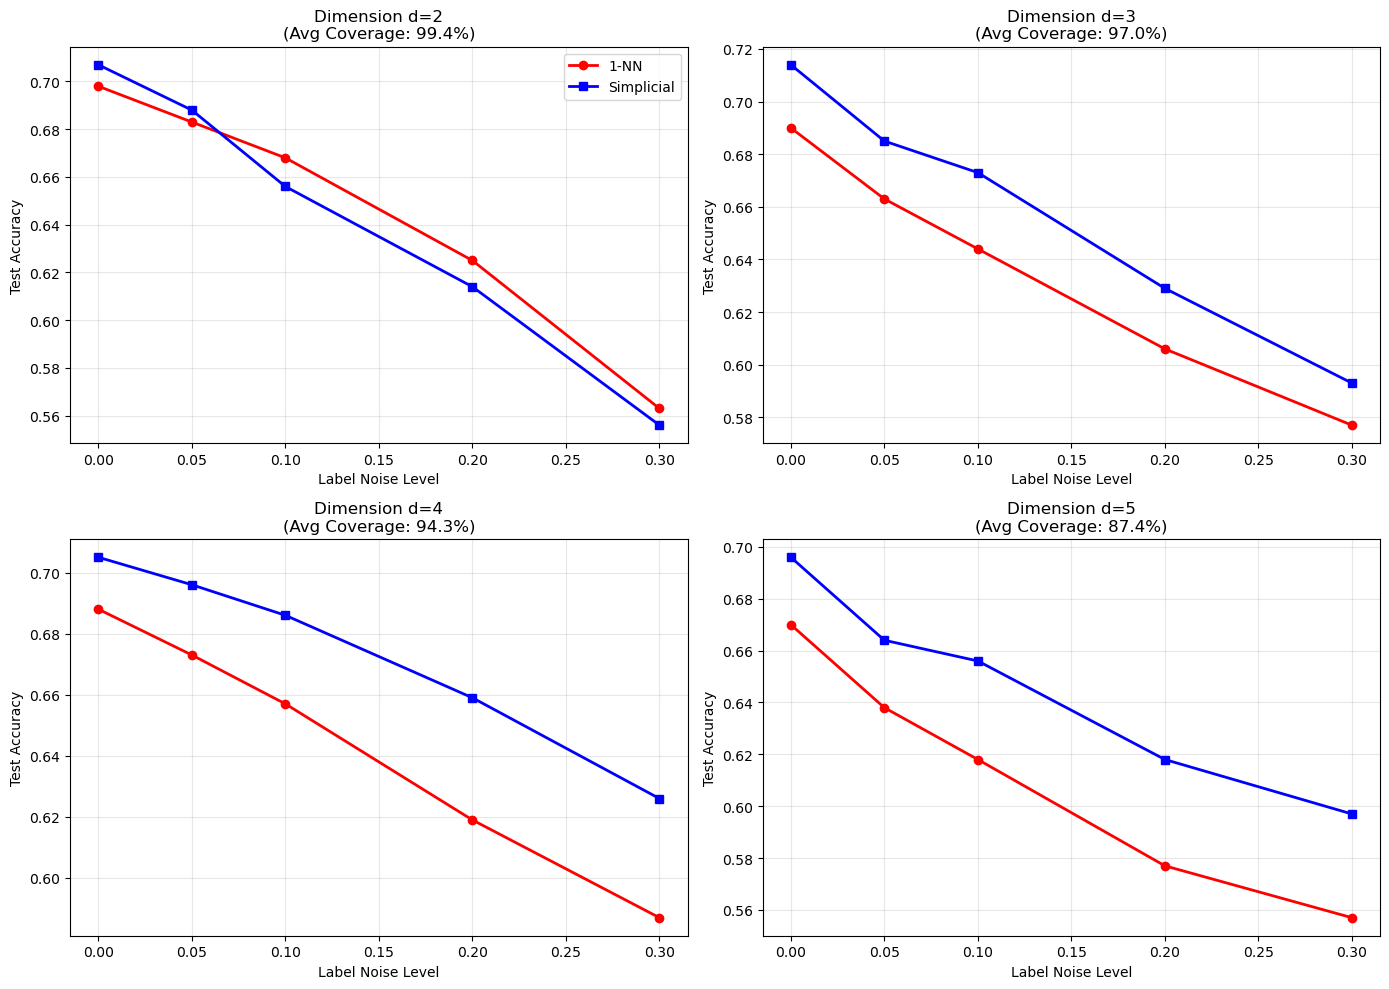

In [12]:
d_values = range(2, 6) 
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)

n_train = 1500 
n_test = 200

results = {}

print(f"Running Experiment across dimensions {list(d_values)}...")
print(f"Note: Global Delaunay (Simplicial) can be slow for N={n_train} in d>=5.")

for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'simp_acc': [], 'cov': []}
    
    print(f"\nProcessing Dimension d={d}...")
    
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            
            ms = GlobalSimplicialClassifier().fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) == yte))
            
            temp_cov.append(ms.coverage_rate_)
            
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['simp_acc'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, "
              f"Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_acc'], 'b-s', label='Simplicial', linewidth=2)
    
    avg_coverage = np.mean(data['cov'])
    
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})", fontsize=12)
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy")
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


Running Experiment across dimensions [6, 8, 10, 12, 14, 16]...

Processing Dimension d=6 (k=18)...
  Noise 0.00 -> 1NN: 0.691, Simp: 0.729 (Cov: 50.30%)
  Noise 0.05 -> 1NN: 0.674, Simp: 0.713 (Cov: 50.30%)
  Noise 0.10 -> 1NN: 0.667, Simp: 0.710 (Cov: 50.30%)
  Noise 0.20 -> 1NN: 0.634, Simp: 0.678 (Cov: 50.30%)
  Noise 0.30 -> 1NN: 0.578, Simp: 0.621 (Cov: 50.30%)

Processing Dimension d=8 (k=24)...
  Noise 0.00 -> 1NN: 0.686, Simp: 0.696 (Cov: 19.80%)
  Noise 0.05 -> 1NN: 0.675, Simp: 0.686 (Cov: 19.80%)
  Noise 0.10 -> 1NN: 0.662, Simp: 0.668 (Cov: 19.80%)
  Noise 0.20 -> 1NN: 0.624, Simp: 0.634 (Cov: 19.80%)
  Noise 0.30 -> 1NN: 0.560, Simp: 0.572 (Cov: 19.80%)

Processing Dimension d=10 (k=30)...
  Noise 0.00 -> 1NN: 0.666, Simp: 0.675 (Cov: 8.10%)
  Noise 0.05 -> 1NN: 0.657, Simp: 0.662 (Cov: 8.10%)
  Noise 0.10 -> 1NN: 0.629, Simp: 0.640 (Cov: 8.10%)
  Noise 0.20 -> 1NN: 0.600, Simp: 0.603 (Cov: 8.10%)
  Noise 0.30 -> 1NN: 0.577, Simp: 0.573 (Cov: 8.10%)

Processing Dimension d

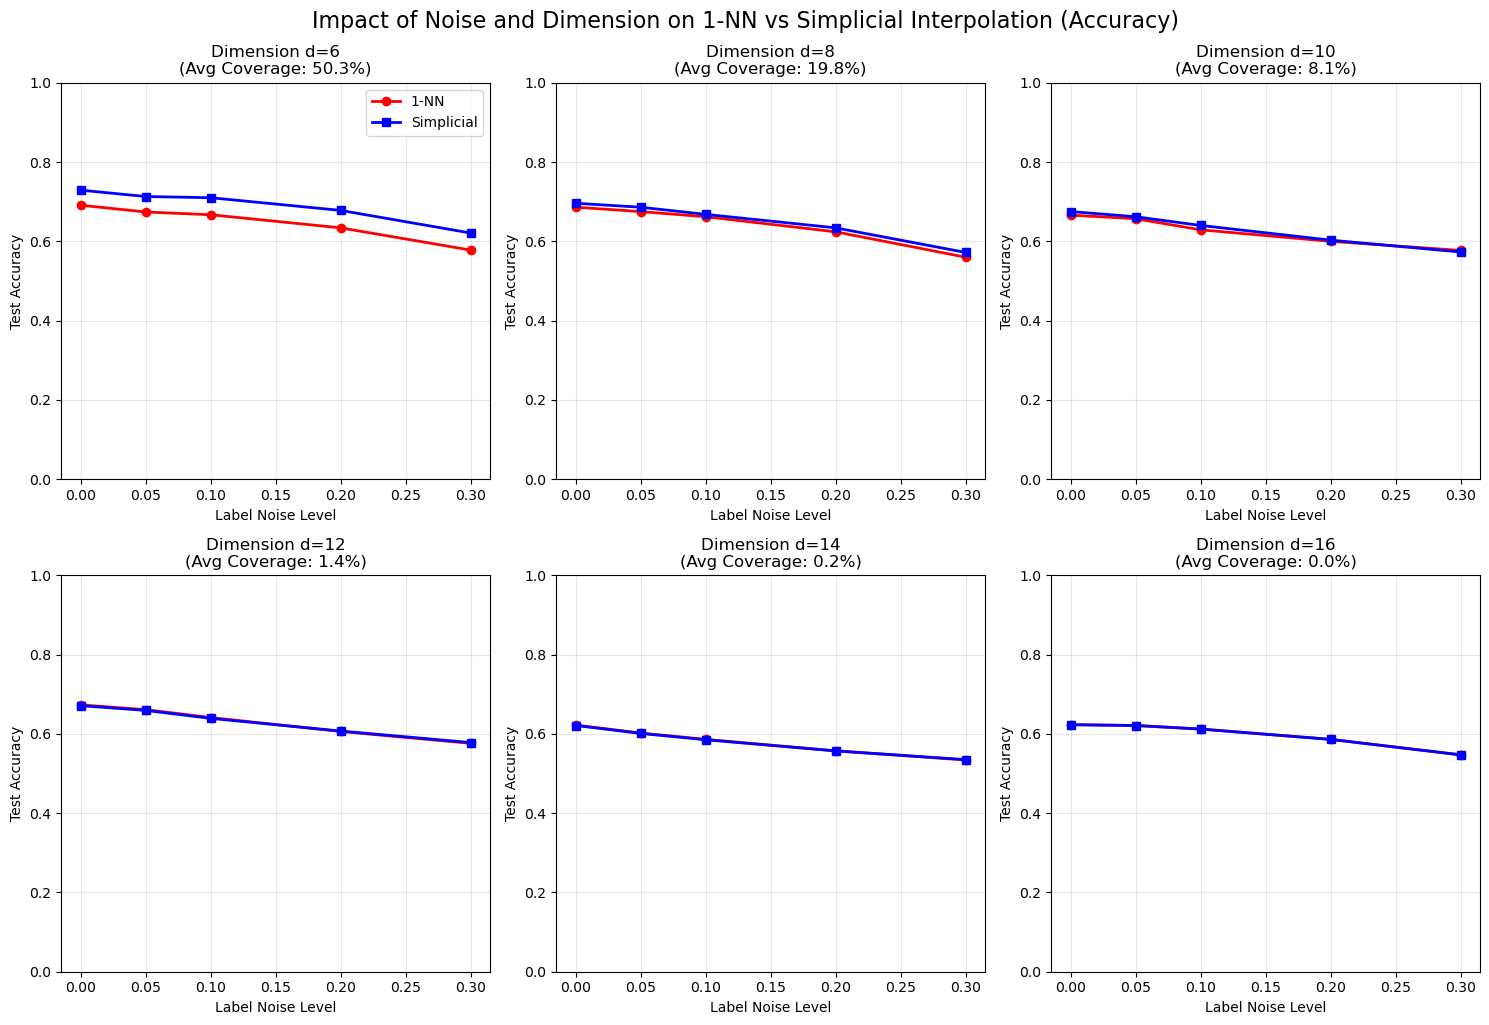

In [5]:
d_values = range(6, 17, 2)
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)
n_train = 20000
n_test = 200
results = {}
print(f"Running Experiment across dimensions {list(d_values)}...")
for d in d_values:
    results[d] = {'noise': [], '1nn_acc': [], 'simp_acc': [], 'cov': []}
    k_simplicial = d * 3
    print(f"\nProcessing Dimension d={d} (k={k_simplicial})...")
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        for s in seeds:
            X_total, y_noisy_total, y_clean_total = make_logistic_gaussian_data(
                n_train + n_test, d, gamma=2.0, p_noise=noise, seed=s
            )
            Xtr = X_total[:n_train]
            ytr = y_noisy_total[:n_train]
            Xte = X_total[n_train:]
            yte = y_clean_total[n_train:]
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) == yte))
            ms = LocalSimplicialClassifier(k=k_simplicial).fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) == yte))
            temp_cov.append(ms.coverage_rate_)
        results[d]['noise'].append(noise)
        results[d]['1nn_acc'].append(np.mean(temp_1nn))
        results[d]['simp_acc'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    ax.plot(data['noise'], data['1nn_acc'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_acc'], 'b-s', label='Simplicial', linewidth=2)
    avg_coverage = np.mean(data['cov'])
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})")
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Accuracy")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()
plt.tight_layout()
plt.suptitle("Impact of Noise and Dimension on 1-NN vs Simplicial Interpolation (Accuracy)", y=1.02, fontsize=16)
plt.show()

Simulating Simplicial Interpolation (d=10)...


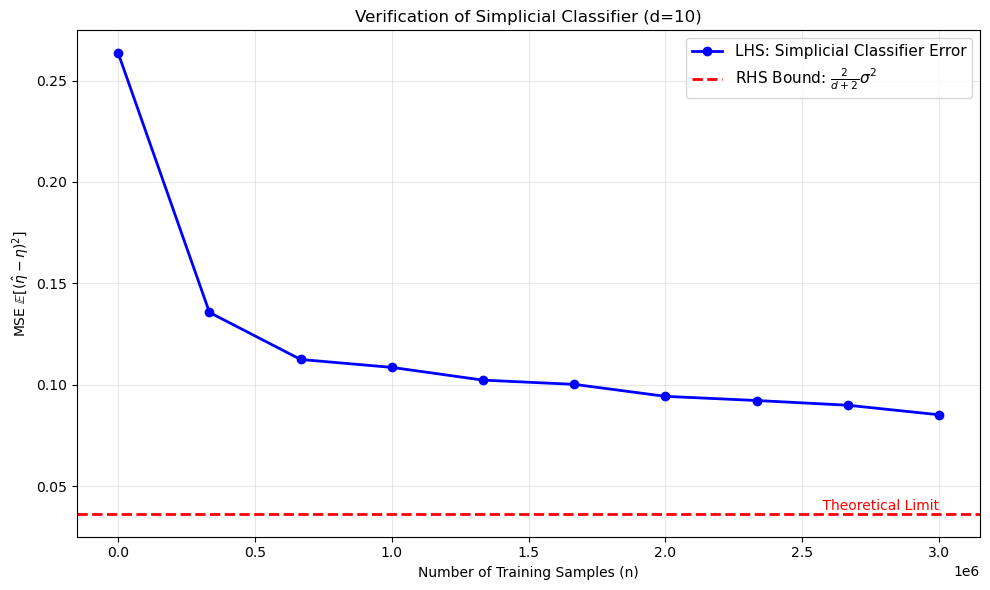

In [6]:
def get_true_eta(X, u, gamma, p_noise):
    """Calculates TRUE P(Y=1|X)"""
    eta_clean = sigmoid(gamma * (X @ u))
    eta_true = eta_clean * (1 - p_noise) + (1 - eta_clean) * p_noise
    return eta_true

def verify_simplicial(d=2, max_n=2500, p_noise=0.2, k_neighbors=15):
    n_test = 2000
    rng_test = np.random.default_rng(42)
    X_test = rng_test.uniform(-1.5, 1.5, size=(n_test, d))
    
    u_fixed = rng_test.normal(0.0, 1.0, size=d)
    u_fixed /= np.linalg.norm(u_fixed)
    
    eta_test = get_true_eta(X_test, u_fixed, gamma=2.0, p_noise=p_noise)
    
    irreducible_error = np.mean(eta_test * (1 - eta_test))
    rhs_bound = (2 / (d + 2)) * irreducible_error
    
    n_samples_list = np.linspace(100, max_n, 10, dtype=int)
    lhs_values = []
    
    print(f"Simulating Simplicial Interpolation (d={d})...")
    
    for n_train in n_samples_list:
        rng = np.random.default_rng()
        X_train = rng.normal(0.0, 1.0, size=(n_train, d))
        
        eta_train = get_true_eta(X_train, u_fixed, gamma=2.0, p_noise=p_noise)
        y_train = (rng.random(n_train) < eta_train).astype(int)
        
        model = LocalSimplicialClassifier(k=k_neighbors)
        model.fit(X_train, y_train)
        
        eta_hat = model.predict_proba(X_test)
        
        mse = np.mean((eta_hat - eta_test)**2)
        lhs_values.append(mse)
        
    return n_samples_list, lhs_values, rhs_bound

D = 10
K = 40
P_NOISE = 0.2

n_vals, lhs, rhs = verify_simplicial(d=D, max_n=3000000, p_noise=P_NOISE, k_neighbors=K)

plt.figure(figsize=(10, 6))

plt.plot(n_vals, lhs, marker='o', color='blue', linewidth=2, label=r'LHS: Simplicial Classifier Error')
plt.axhline(y=rhs, color='red', linestyle='--', linewidth=2, label=r'RHS Bound: $\frac{2}{d+2} \sigma^2$')

plt.xlabel('Number of Training Samples (n)')
plt.ylabel(r'MSE $\mathbb{E}[(\hat{\eta} - \eta)^2]$')
plt.title(f'Verification of Simplicial Classifier (d={D})')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.text(n_vals[-1], rhs*1.05, ' Theoretical Limit', color='red', ha='right')

plt.tight_layout()
plt.show()

Simulating Global Simplicial Interpolation (d=4)...
  n=100: MSE=0.14192 (Cov=62.4%)
  n=6755: MSE=0.07546 (Cov=99.4%)
  n=13411: MSE=0.07826 (Cov=99.6%)
  n=20066: MSE=0.07751 (Cov=100.0%)
  n=26722: MSE=0.07650 (Cov=100.0%)
  n=33377: MSE=0.07571 (Cov=100.0%)
  n=40033: MSE=0.07580 (Cov=100.0%)
  n=46688: MSE=0.07676 (Cov=100.0%)
  n=53344: MSE=0.07439 (Cov=100.0%)
  n=60000: MSE=0.07437 (Cov=100.0%)


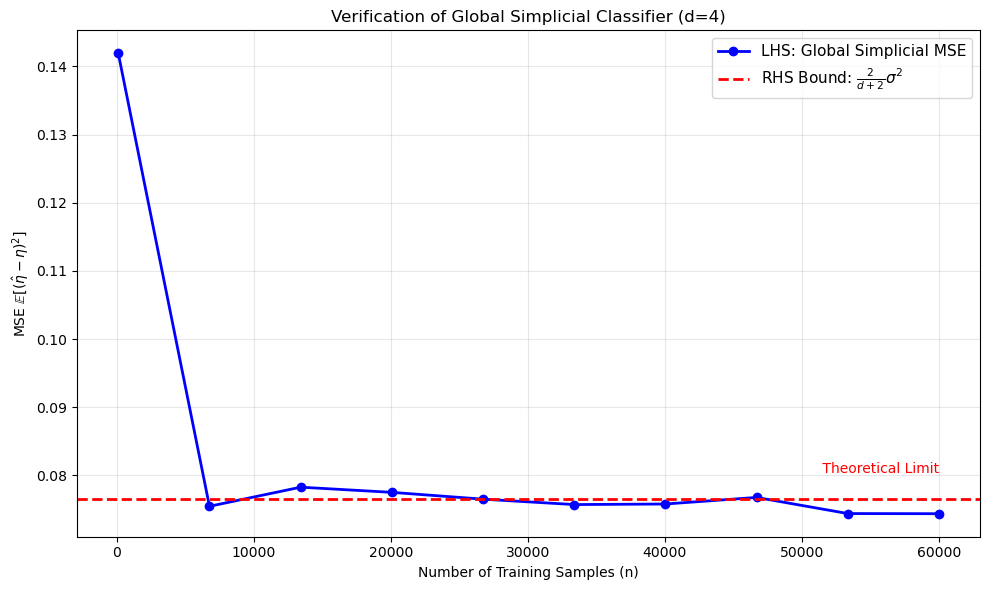

In [21]:
def get_true_eta(X, u, gamma, p_noise):
    """Calculates TRUE P(Y=1|X)"""
    eta_clean = sigmoid(gamma * (X @ u))
    eta_true = eta_clean * (1 - p_noise) + (1 - eta_clean) * p_noise
    return eta_true

def verify_global_simplicial(d=2, max_n=2500, p_noise=0.2):
    """
    Verifies the Global Simplicial Classifier against the theoretical bound.
    Note: Training and Test distributions must match for the Convex Hull assumption to hold.
    """
    n_test = 2000
    rng_test = np.random.default_rng(42)
    
    X_test = rng_test.uniform(-1.0, 1.0, size=(n_test, d))
    
    u_fixed = rng_test.normal(0.0, 1.0, size=d)
    u_fixed /= np.linalg.norm(u_fixed)
    
    eta_test = get_true_eta(X_test, u_fixed, gamma=2.0, p_noise=p_noise)
    
    irreducible_error = np.mean(eta_test * (1 - eta_test))
    rhs_bound = (2 / (d + 2)) * irreducible_error
    
    n_samples_list = np.linspace(100, max_n, 10, dtype=int)
    lhs_values = []
    coverage_values = []
    
    print(f"Simulating Global Simplicial Interpolation (d={d})...")
    
    for n_train in n_samples_list:
        rng = np.random.default_rng()
        
        X_train = rng.uniform(-1.05, 1.05, size=(n_train, d)) 
        
        eta_train = get_true_eta(X_train, u_fixed, gamma=2.0, p_noise=p_noise)
        y_train = (rng.random(n_train) < eta_train).astype(int)
        
        model = GlobalSimplicialClassifier()
        model.fit(X_train, y_train)
        
        eta_hat = model.predict_proba(X_test)
        
        mse = np.mean((eta_hat - eta_test)**2)
        lhs_values.append(mse)
        coverage_values.append(model.coverage_rate_)
        
        print(f"  n={n_train}: MSE={mse:.5f} (Cov={model.coverage_rate_:.1%})")
        
    return n_samples_list, lhs_values, rhs_bound, coverage_values

D = 4
P_NOISE = 0.2
MAX_N = 60000 

n_vals, lhs, rhs, covs = verify_global_simplicial(d=D, max_n=MAX_N, p_noise=P_NOISE)

plt.figure(figsize=(10, 6))

plt.plot(n_vals, lhs, marker='o', color='blue', linewidth=2, label=r'LHS: Global Simplicial MSE')
plt.axhline(y=rhs, color='red', linestyle='--', linewidth=2, label=r'RHS Bound: $\frac{2}{d+2} \sigma^2$')

plt.xlabel('Number of Training Samples (n)')
plt.ylabel(r'MSE $\mathbb{E}[(\hat{\eta} - \eta)^2]$')
plt.title(f'Verification of Global Simplicial Classifier (d={D})')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add text for the bound
plt.text(n_vals[-1], rhs*1.05, ' Theoretical Limit', color='red', ha='right')

plt.tight_layout()
plt.show()